In [1]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


### IMDB 리뷰 데이터

케라스에서 제공하는 IMDB 리뷰 데이터는 훈련 데이터와 테스트 데이터를 50:50 비율로 구분해서 제공한다.

num_words는 이 데이터에서 등장 빈도 순위로 몇 번째에 해당하는 단어까지 갖고 올 것인지 조절한다.

20,000이란 값은 등장 빈도 순위가 1 ~ 20,000에 해당하는 단어만 갖고 오게 된다.

따라서 단어의 종류는 20,000개가 되므로 단어 집합의 크기는 20,000이 된다.

In [2]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)
# 영화 리뷰는 x_train에, 감성 정보는 y_train에 저장된다.

# restore np.load for future normal usage
np.load = np_load_old

17465344/17464789 [==============================] - 1s 0us/step


**훈련용 데이터의 개수, 테스트 데이터의 개수, 카테고리의 수 출력**

In [3]:
print('훈련 데이터: {}'.format(len(x_train)))
print('테스트 데이터: {}'.format(len(x_test)))
num_classes = max(y_train) + 1
print('카테고리: {}'.format(num_classes))

훈련 데이터: 25000
테스트 데이터: 25000
카테고리: 2


**훈련 데이터 출력해보기**

25,000개의 영화 리뷰 중 첫번째 리뷰 텍스트와 그 리뷰에 대한 레이블을 출력

In [4]:
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


전체 25,000개의 훈련 데이터에서 각 단어들이 몇 번 등장하는 지의 빈도에 따라서 인덱스를 부여한 것이다.

1이라는 숫자는 이 단어가 이 데이터에서 등장 빈도가 1등이라는 뜻이다.

973이라는 숫자는 이 단어가 데이터에서 973번째로 빈도수가 높은 단어라는 뜻이다.

In [5]:
print(y_train[0])

1


1의 의미는 첫번째 훈련데이터가 2개의 카테고리 중 1에 해당하는 카테고리임을 의미한다.

감성 정보로서 0 또는 1의 값을 가지는데, 이 경우 긍정을 의미하는 1의 값을 갖는다.

**x_train 데이터의 길이 확인**

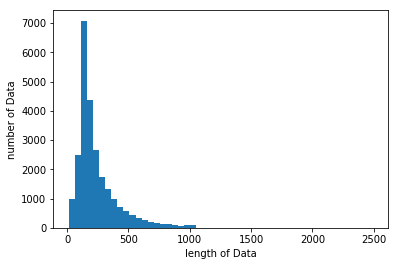

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

x_train 데이터의 각 길이는 전부 다른데 대체적으로 500이하의 길이를 가지며, 특히 100~300길이를 가진 데이터가 가장 많은 것을 확인할 수 있다.

가장 긴 길이를 가진 데이터는 길이가 1,000이 넘는 것도 확인할 수 있다.

### 훈련셋과 검증셋 분리

In [0]:
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

### 데이터셋 전처리

각 훈련 데이터는 문장의 길이가 다르기 때문에, 모델이 처리할 수 있도록 길이를 동일하게 해주어야 한다.

이때 사용하는 것이 pad_sequences()이다.

길이는 maxlen에 넣는 값으로 정해진다.

훈련 데이터가 정한 길이를 초과하면 초과분을 삭제하고, 부족하면 0으로 채운다.

In [0]:
x_train = sequence.pad_sequences(x_train, maxlen=200)
x_val = sequence.pad_sequences(x_val, maxlen=200)
x_test = sequence.pad_sequences(x_test, maxlen=200)

### 모델 구성
Embedding()은 두개 의 인자를 받는데, 첫번째 인자는 단어 집합의 크기이며 두번째 인자는 임베딩 후의 벡터 크기(128) 이다.

즉, 입력 데이터에서 모든 단어는 128 차원을 가진 임베딩 벡터로 표현된다.

출력층은 활성화 함수로 시그모이드 함수를 갖는 뉴런 하나를 사용한다.

시그모이드 함수를 사용하면 0 또는 1의 결과를 도출해낼 수 있기 때문에 분류해야하는 카테고리가 두 개일 경우에 출력층에서 사용한다.

In [9]:
model = Sequential()
model.add(Embedding(20000, 128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

W0805 04:48:41.532657 140302101317504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 04:48:41.578017 140302101317504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 04:48:41.587760 140302101317504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [10]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________
None


### 모델 학습과정 설정
긍정인지 부정인지에 대한 이진 판별값이 출력되기 때문에, 손실함수는 binary_crossentropy를 사용한다.

최적화 함수는 adam을 사용한다.

에포크마다 정확도를 구하기 위해 accuracy를 추가한다.

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) 

# 모델 학습시키기
hist = model.fit(x_train,
                 y_train,
                 batch_size=64,
                 epochs=25,
                 validation_data=(x_val, y_val))

W0805 04:48:41.952935 140302101317504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 04:48:41.984882 140302101317504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0805 04:48:41.993655 140302101317504 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0805 04:48:43.079457 140302101317504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. P

Train on 20000 samples, validate on 5000 samples
Epoch 1/25
20000/20000 [==============================] - 119s 6ms/step - loss: 0.4297 - acc: 0.8004 - val_loss: 0.3583 - val_acc: 0.8492
Epoch 2/25
20000/20000 [==============================] - 114s 6ms/step - loss: 0.2304 - acc: 0.9102 - val_loss: 0.3535 - val_acc: 0.8490
Epoch 3/25
20000/20000 [==============================] - 114s 6ms/step - loss: 0.1384 - acc: 0.9519 - val_loss: 0.3830 - val_acc: 0.8704
Epoch 4/25
20000/20000 [==============================] - 114s 6ms/step - loss: 0.0985 - acc: 0.9657 - val_loss: 0.4749 - val_acc: 0.8398
Epoch 5/25
20000/20000 [==============================] - 113s 6ms/step - loss: 0.0650 - acc: 0.9782 - val_loss: 0.5099 - val_acc: 0.8644
Epoch 6/25
20000/20000 [==============================] - 113s 6ms/step - loss: 0.0582 - acc: 0.9799 - val_loss: 0.5388 - val_acc: 0.8536
Epoch 7/25
20000/20000 [==============================] - 114s 6ms/step - loss: 0.0415 - acc: 0.9868 - val_loss: 0.5680 - v

### 학습과정 확인

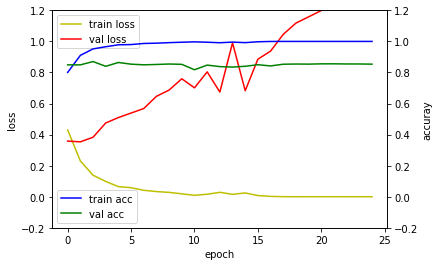

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### 테스트 데이터에 대해서 정확도 평가
훈련된 모델에 대해서 테스트 데이터로 정확도를 평가해 본다.

In [13]:
scores = model.evaluate(x_train, y_train, verbose=0)
print("정확도: %.4f%%" % (scores[1]*100))

정확도: 100.0000%


### 모델 평가

In [14]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

25000/25000 [==============================] - 30s 1ms/step
## evaluation loss and_metrics ##
[1.3897732795906066, 0.8488]
